# Step 5: Recommender System

To implement the image recommendation functionality for our project, we are following these steps:

1. Image Classification: Utilize our existing machine learning model to classify the user-provided reference image into one of the eight flower classes.
2. Similarity Detection:
    - Use a Convolutional Neural Network (CNN) to extract feature vectors from each image in our database, then store it in `./data/recommender-database.csv`, to allow for efficient retrieval during the recommendation process.
    - Use the same CNN to extract a feature vector from our the user-provided reference image.
    - Apply a K-Means unsupervised machine learning model to cluster the reference image's feature vector with those of the images in our database. We select the number of cluster $k$ dynamically using the number of images need to be recommended.
3. Recommending Images: Once we have the clusters, we would recommend images from the cluster that the reference image belongs to. To do this accurately, we are using [Scikit-learn implementation of cosine similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to find the most similar images to the reference image within that cluster.

In [4]:
# Imports and environmental setups
import pandas as pd
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image

# Custom utils functions
from utils import dataset
from utils.visualization import plot_learning_curve
from utils.visualization import visualize_16predictions
from utils.glob import TARGET_IMG_SIZE


# Reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Misc.
plt.style.use('ggplot')
model_name = 'rec-kmeans'
dir_raw_dataset = '../data/raw/'
dir_recommender_database = 'C:/TaiLieuHocTap/rMIT/A_2023/ML_A23/Rmit-assignment2/data/recommender-database'
path_recommender_database = '../data/recommender-database.csv'
dir_log = '../log/' + model_name
dir_models = '../models/'
path_model = dir_models + model_name


# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
GPU is NOT AVAILABLE


In [5]:
rFlower = dataset.load(dir_recommender_database)
rFlower.head()

,ImgPath,FileType,Width,Height,Ratio,Mode,Bands,Transparency,Animated,Class
0,Baby/000001.jpg,jpg,500,667,0.749625,RGB,R G B,False,False,Baby
1,Baby/000002.jpg,jpg,1200,1600,0.750000,RGB,R G B,False,False,Baby
2,Baby/000003.jpg,jpg,2872,2872,1.000000,RGB,R G B,False,False,Baby
3,Baby/000004.jpg,jpg,1667,2334,0.714225,RGB,R G B,False,False,Baby
4,Baby/000005.jpg,jpg,2495,2560,0.974609,RGB,R G B,False,False,Baby


In [6]:
rFlower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4685 entries, 0 to 4684
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       4685 non-null   object 
 1   FileType      4685 non-null   object 
 2   Width         4685 non-null   int64  
 3   Height        4685 non-null   int64  
 4   Ratio         4685 non-null   float64
 5   Mode          4685 non-null   object 
 6   Bands         4685 non-null   object 
 7   Transparency  4685 non-null   bool   
 8   Animated      4685 non-null   bool   
 9   Class         4685 non-null   object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 302.1+ KB


In [7]:
print("Number of images: ", len(rFlower))


Number of images:  4685


In [10]:
dtbase = dir_recommender_database
imgs = []
labels = [] 
for folder in os.listdir(dtbase):
    for img in os.listdir(dtbase + '/' + folder + '/'):
        img = Image.open(dtbase + '/' + folder + '/' + img)
        img = img.resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE))
        img = np.array(img)
        img = img.astype('float32')
        img /= 255
        imgs.append(img)
        labels.append(folder)

In [11]:
for i in range(len(labels)):
    if labels[i] == 'Baby':
        labels[i] = 0
    elif labels[i] == 'Calimerio':
        labels[i] = 1
    elif labels[i] == 'Chysanthemum':
        labels[i] = 2
    elif labels[i] == 'Hydrageas':
        labels[i] = 3
    elif labels[i] == 'Lisianthus':
        labels[i] = 4
    elif labels[i] == 'Pingpong':
        labels[i] = 5
    elif labels[i] == 'Rosy':
        labels[i] = 6
    elif labels[i] == 'Tana':
        labels[i] = 7
        



In [12]:
imgs = np.array(imgs)
labels = np.array(labels)
print(imgs.shape)
print(labels.shape)

(4685, 256, 256, 3)
(4685,)


In [13]:
tensor_array = tf.convert_to_tensor(imgs)
tensor_labels = tf.convert_to_tensor(labels)

print(tensor_array.shape)
print(tensor_labels.shape)

(4685, 256, 256, 3)
(4685,)


In [ ]:
#load the CNN models
from keras.models import load_model
fe = load_model('../models/clf-cnn')
print(fe.summary())

In [49]:
features1 = fe.predict(tensor_array)
# Normalize features vectors

features1 = features1.reshape(features1.shape[0], -1)  
features1 = (features1 - np.mean(features1, axis=0)) / np.std(features1, axis=0)
#save to csv file
import pandas as pd
csv_df = pd.DataFrame(features1)
csv_df.to_csv('../data/recommender-database.csv', index=False)

147/147 [==============================] - 10s 65ms/step


In [15]:
#load the extracted features from the CNN model
tensor_arr = np.load('../data/tensor_imgs.npy')


In [50]:
db_features = fe.predict(tensor_arr)

147/147 [==============================] - 15s 96ms/step


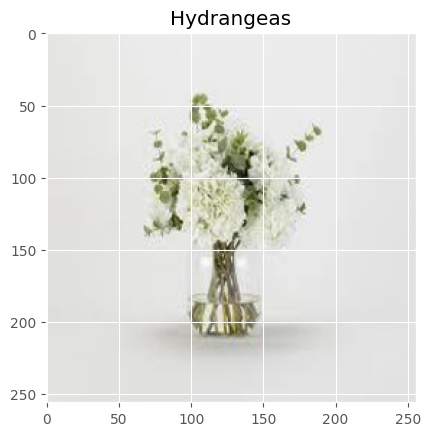

In [51]:
#open a random image in recommender database
import random
def open_random_image():
    path = dir_recommender_database + '/'
    folder = random.choice(os.listdir(path))
    img = random.choice(os.listdir(path + folder))
    img = Image.open(path + folder + '/' + img)
    img = img.resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE))
    img = np.array(img)
    img = img.astype('float32')
    img /= 255
    plt.imshow(img)
    plt.title(folder)
    plt.show()
    return img

random_img = open_random_image()


In [18]:
#extract 
def extract_features(random_img):
    random_img = random_img.reshape(1, TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)
    features = model.predict(random_img)
    features = features.reshape(features.shape[0], -1)  
    return features
RanImgFeatures = extract_features(random_img)
print(RanImgFeatures)

1/1 [==============================] - 0s 28ms/step
[[ 2.0064876  -0.6197569  -0.03118997  0.5030791  -0.28249282  1.7641894
  -2.723354   -1.3003404 ]]


In [19]:
classes = dataset.get_class_names(dir_raw_dataset)
print("Classes:", classes)

Classes: ['Baby', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']


4. Recommending Images:
   - Within the cluster that the reference image belongs to, calculate the cosine similarity between the reference image's feature vector and the feature vectors of the images in the cluster.
   - Utilize the Scikit-learn implementation of cosine similarity to find the most similar images to the reference image within the cluster.
   - Select the top recommended images based on their cosine similarity scores.

# working with the recommender dataset

In [84]:
recomData = pd.read_csv('../data/recommender-database.csv')
recomData.head(10)


,0,1,2,3,4,5,6,7
0,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753
1,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753
2,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753
3,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753
4,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753
5,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753
6,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753
7,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753
8,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753
9,0.398076,-0.402336,-0.403878,-0.366279,-0.38772,0.405914,-0.251103,-0.396753


In [86]:
features = recomData.iloc[:,1:].values
features.shape

(4685, 7)

In [56]:
# RecomFe = recomData.to_numpy()
# print(RecomFe)

[[ 0.39807558 -0.4023364  -0.40387833 ...  0.40591365 -0.25110295
  -0.3967527 ]
 [ 0.39807558 -0.4023364  -0.40387833 ...  0.40591365 -0.25110295
  -0.3967527 ]
 [ 0.39807558 -0.4023364  -0.40387833 ...  0.40591365 -0.25110295
  -0.3967527 ]
 ...
 [ 0.39807558 -0.4023364  -0.40387833 ...  0.40591365 -0.25110295
  -0.3967527 ]
 [ 0.39807558 -0.4023364  -0.40387833 ...  0.40591365 -0.25110295
  -0.3967527 ]
 [ 0.3980915  -0.40234137 -0.40387905 ...  0.40591744 -0.25116736
  -0.3967527 ]]


In [77]:
#calculate the distance between the random image and the images in the recommender database
def calculate_distance(RanImgFeatures, RecomFe):
    distance = np.linalg.norm(RanImgFeatures - RecomFe, axis=1)
    return distance
distance = calculate_distance(RanImgFeatures, recomData)

In [79]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_images(distance, recomData, num):
    idx = np.argsort(distance)[:num]
    print(idx)
    print(distance[idx])
    print(recomData.iloc[idx])
    return idx

top_image_names = recommend_images(distance, recomData, 10)


[4044 4003 3997 4093 4094  510 1597 1598 2622 4125]
[2.72316145 3.4284281  3.48526782 3.509022   3.509022   3.509022
 3.509022   3.509022   3.509022   3.509022  ]
      0.39807558  -0.4023364  -0.40387833  -0.36627936  -0.38771966   
4044    0.795944   -0.750886    -0.567648    -0.620346    -0.506580  \
4003    0.590470   -0.352210     0.356674     0.670045     0.350504   
3997    1.232463   -0.910595     0.029996     0.447124     0.122203   
4093    0.398091   -0.402341    -0.403879    -0.366391    -0.387717   
4094    0.398091   -0.402341    -0.403879    -0.366391    -0.387717   
510     0.398091   -0.402341    -0.403879    -0.366391    -0.387717   
1597    0.398091   -0.402341    -0.403879    -0.366391    -0.387717   
1598    0.398091   -0.402341    -0.403879    -0.366391    -0.387717   
2622    0.398091   -0.402341    -0.403879    -0.366391    -0.387717   
4125    0.398091   -0.402341    -0.403879    -0.366391    -0.387717   

      0.40591365  -0.25110295  -0.3967527  
4044    0.5

In [37]:
from sklearn.cluster import KMeans

clu = KMeans(init='k-means++', n_init = 'auto')

In [ ]:

wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(recomData)
    wcss.append(kmeans.inertia_)

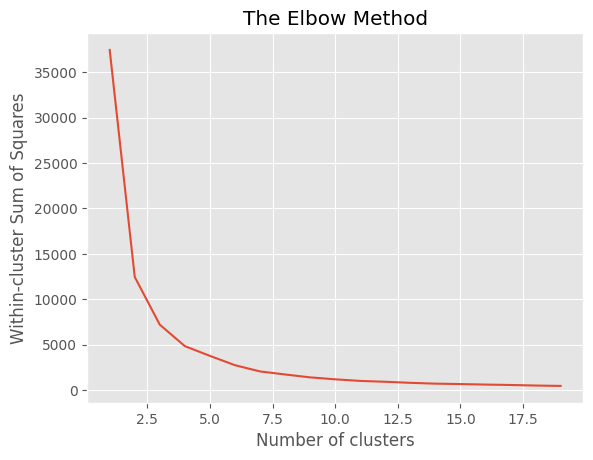

In [22]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()

In [ ]:
#using silhouette score to find the optimal number of clusters
from sklearn.metrics import silhouette_score
silhouette_scores = []
for n_cluster in range(2, 20):
    silhouette_scores.append( 
        silhouette_score(recomData, KMeans(n_clusters = n_cluster).fit_predict(recomData)))
    


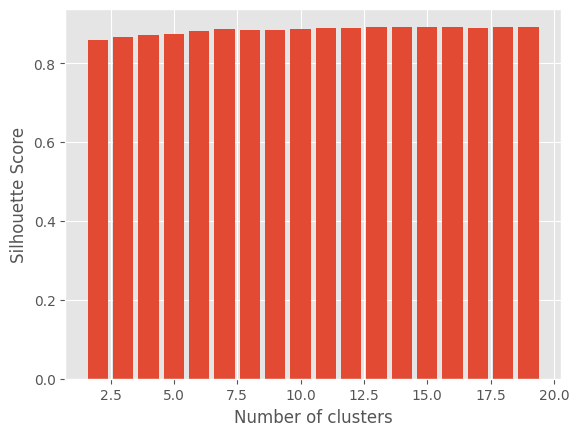

In [24]:
# Plotting a bar graph to compare the results
k = range(2,20)
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 12)
plt.ylabel('Silhouette Score', fontsize = 12)
plt.show()


In [25]:
#train the clustering model 
k = 13
kmeans = KMeans(n_clusters=k, random_state=42)
prediction = kmeans.fit_predict(recomData)
prediction 

c:\TaiLieuHocTap\RMIT\A_2023\ML_A23\rmit-assignment2\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0])

In [26]:
onehot = keras.utils.to_categorical(prediction)
onehot.shape

(4685, 13)

In [ ]:
### testing code ###
def plotImages(imgs, title):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip( imgs, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.title(title)
    plt.show()
    
def getImagesByLabel(label):
    imgs = []
    for i in range(len(recomData)):
        if recomData['label'][i] == label:
            img = recomData.iloc[i, 0:196608].values.reshape(256, 256, 3)
            imgs.append(img)
    return imgs

def getImagesByCluster(cluster):
    imgs = []
    for i in range(len(recomData)):
        if recomData['cluster'][i] == cluster:
            img = recomData.iloc[i, 0:196608].values.reshape(256, 256, 3)
            imgs.append(img)
    return imgs

#kmeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit()